# Workshop on vision based localization

Course: Spatial Reasoning from Sensor Data, https://www.iss.nus.edu.sg/executive-education/course/detail/spatial-reasoning-from-sensor--data/artificial-intelligence

Contact: Tian Jing

Email: tianjing@nus.edu.sg

## Objective

- The objective of this workshop is to perform place recognition and localization

## Reference

- Dataset: Scene recognition, https://www.cc.gatech.edu/~hays/compvision/proj4/. The place dataset is downloaded at https://www.cc.gatech.edu/~hays/compvision/proj4/data.zip
    
- This workshop code is modified from the original Caffe version in the following reference to be Keras version.

- Refrence: 'Benchmark for Image Retrieval (BKIR)', https://github.com/willard-yuan/cnn-cbir-benchmark



In [1]:
import cv2
import os
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models.vgg as vgg

print("PyTorch version is", torch.__version__)

# Use GPU if available else revert to CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device being used:", device)


PyTorch version is 2.1.0+cu121
Device being used: cuda:0


In [2]:
# Then you’ll see a link, click on that link, allow access
# Copy the code that pops up, paste it in the box, hit enter

from google.colab import drive
drive.mount('/content/gdrive')

# Change working directory to be current folder, please keep ''/content/gdrive/My Drive/XXX' in the path and change XXX to be your own folder.
# The path is case sensitive.
import os
os.chdir('/content/gdrive/My Drive/SRSD/Day2')
!ls

Mounted at /content/gdrive
archive   SRSD_Day2_wk_place_recognition_keras_yourname.ipynb
data	  SRSD_Day2_wk_place_recognition_pytorch_yourname.ipynb
data_old


## Prepare gallery images set and query images set

In [3]:
# Prepare the gallery folder and image file list
gallery_image_folder_name = 'data/scene/gallery'
gallery_image_file_list = []
gallery_image_class_list = sorted(os.listdir(gallery_image_folder_name))
for subfolder in gallery_image_class_list:
    file_list = sorted(os.listdir(gallery_image_folder_name + '/' + subfolder))
    for file in file_list:
        gallery_image_file_list.append(gallery_image_folder_name + '/' + subfolder + '/' + file)

print("gallerying: %d classes, %d images" % (len(gallery_image_class_list), len(gallery_image_file_list)))

# Prepare the query folder and image file list
query_image_folder_name = 'data/scene/query'
query_image_file_list = []
query_image_class_list = sorted(os.listdir(query_image_folder_name))
for subfolder in query_image_class_list:
    file_list = sorted(os.listdir(query_image_folder_name + '/' + subfolder))
    for file in file_list:
        query_image_file_list.append(query_image_folder_name + '/' + subfolder + '/' + file)

print("query: %d classes, %d images" % (len(query_image_class_list), len(query_image_file_list)))


gallerying: 15 classes, 1500 images
query: 15 classes, 150 images


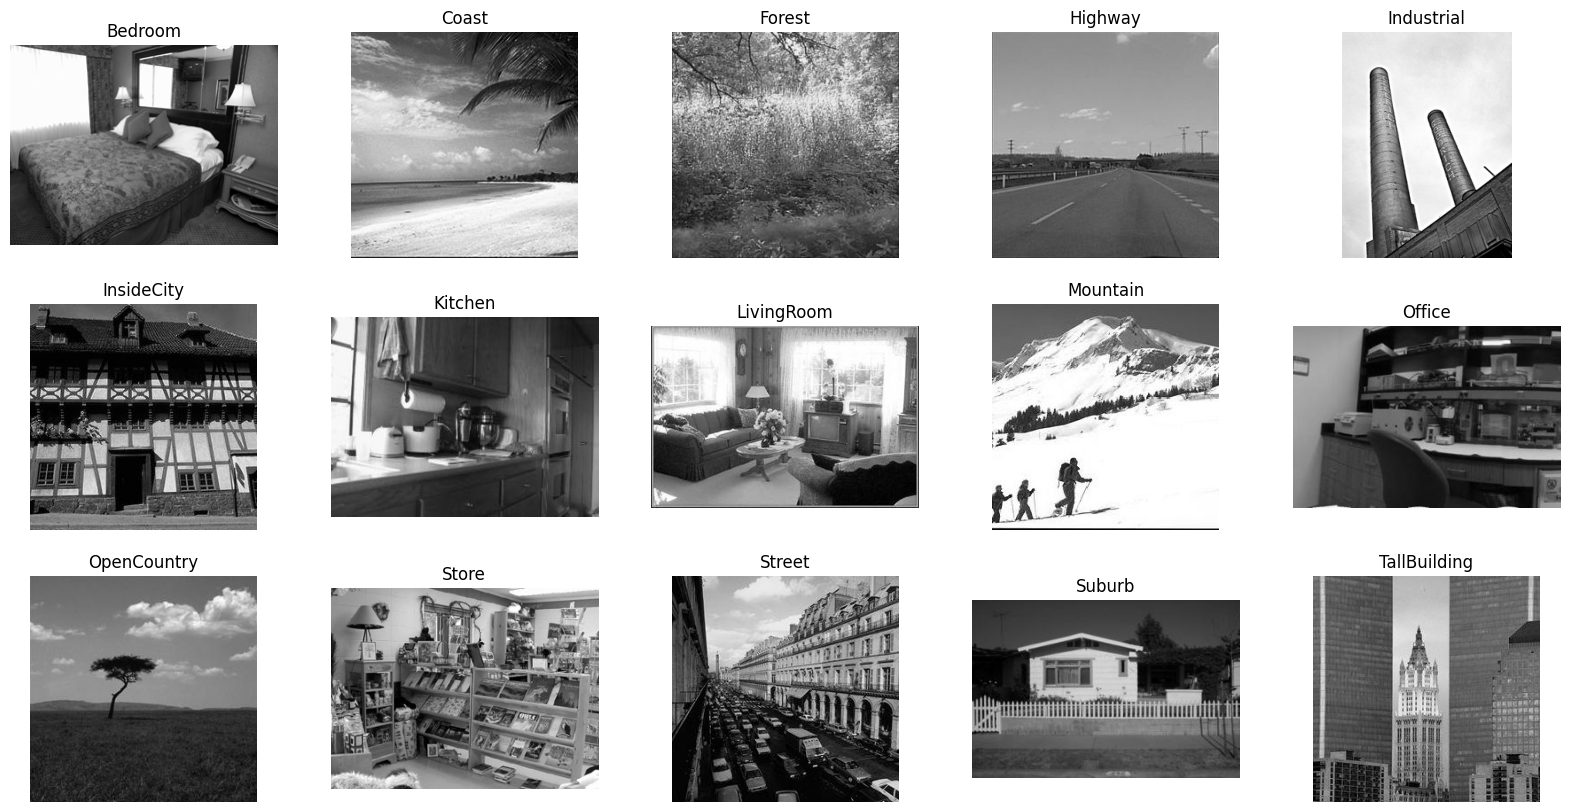

In [4]:
# Illustrate sample gallerying images
gallery_image_folder_name = 'data/scene/gallery'
plt.figure(figsize=(20,10))
i = 0
for subfolder in gallery_image_class_list:
    file_list = sorted(os.listdir(gallery_image_folder_name + '/' + subfolder))
    for file in file_list:
        if '.jpg' in file:
            i = i+1
            plt.subplot(3, 5, i)
            plt.imshow(cv2.imread(gallery_image_folder_name + '/' + subfolder + '/' + file))
            plt.axis("off")
            plt.title(subfolder)
            break
plt.show()


In [5]:
# Compare the input query file name and the result file name lists to calculate the precision performance
# For example
# input_file_name: data/scene/gallery/Mountain/image_0076.jpg
# result_file_name_list: a list of top_return files in query results
# Precision: Number of true returned results/Total number of results
# Accuracy: 1: IF there is at least one true returned result; 0: All returned results are wrong
def cal_precision(input_file_name, result_file_name_list):
    num = 0
    input_class = input_file_name.split("/")[3]
    for result_file_name in result_file_name_list:
        result_class = result_file_name.split("/")[3]
        if (input_class == result_class):
            num = num+1
    return (num/len(result_file_name_list))

def cal_accuracy(input_file_name, result_file_name_list):
    result = 0
    input_class = input_file_name.split("/")[3]
    for result_file_name in result_file_name_list:
        result_class = result_file_name.split("/")[3]
        if (input_class == result_class):
            result = 1
            break
    return (result)

def cal_vec_dist(vec1, vec2):
    '''
    Description: calculate the Euclidean Distance of two vectors
    '''
    return np.linalg.norm(vec1 - vec2)


## Neural Codes: Step 0, Define functions

- Reference: Artem Babenko, Anton Slesarev, Alexandr Chigorin, Victor Lempitsky, "Neural Codes for Image Retrieval," ECCV 2014, https://arxiv.org/abs/1404.1777

- Process
    - Extract `fc2` layer output as the features
    - Apply cosine similarity (dot product) as the similarity score


In [6]:
# Define VGG baseline model
# The VGG model file (528 MB) will be downloaded from the Internet when you run this code for the first time.

vgg16_original = vgg.vgg16(pretrained=True)
vgg_model_extract_fc2 = vgg16_original
vgg_model_extract_fc2.classifier = torch.nn.Sequential(*list(vgg16_original.classifier.children())[:-1])
vgg_model_extract_fc2.to(device)

# A toy query the input and output dimension for the modified VGG model
temp_in = torch.rand(1, 3, 224, 224)
temp_in = temp_in.to(device)
print("vgg16_modified, input: ", temp_in.shape) # 1*512*7*7

temp_output = vgg_model_extract_fc2(temp_in)
print("vgg16_modified, fc features: ", temp_output.shape) # 1*4096


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 103MB/s]


vgg16_modified, input:  torch.Size([1, 3, 224, 224])
vgg16_modified, fc features:  torch.Size([1, 4096])


In [7]:
# Define the feature extraction function
# Note that the images in the dataset are gray scale images, we need to expand them into RGB images to feed into VGG model
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: torch.cat([x, x, x], 0))])

def extract_vgg_fc_feature_from_list(image_file_list):
    all_feature = []
    for idx, eachFile in enumerate(image_file_list):
        img = Image.open(eachFile)
        x = transform(img).unsqueeze(0).to(device)
        fc2_features = vgg_model_extract_fc2(x).cpu().detach().numpy()
        fc2_features = fc2_features/np.linalg.norm(fc2_features) # normalzie features
        all_feature.append(fc2_features)
    return all_feature


## Neural Codes: Step 1, Feature extraction from from both gallery and query data set

In [8]:
# # Extract features from gallerying images
# gallery_all_feature_vgg_fc = extract_vgg_fc_feature_from_list(gallery_image_file_list)
# print("Dimension of gallery_all_feature_vgg_fc: (%d, %d)" % (len(gallery_all_feature_vgg_fc), gallery_all_feature_vgg_fc[0].shape[1]))
# np.save('data/pt_gallery_all_feature_vgg_fc.npy', gallery_all_feature_vgg_fc)

# # print('Extract features from query images')
# query_all_feature_vgg_fc = extract_vgg_fc_feature_from_list(query_image_file_list)
# print("query_all_feature_vgg_fc: (%d, %d)" % (len(query_all_feature_vgg_fc), query_all_feature_vgg_fc[0].shape[1]))
# np.save('data/pt_query_all_feature_vgg_fc.npy', query_all_feature_vgg_fc)

# # It takes some time to extract features, so we can directly load the pre-extracted features.
gallery_all_feature_vgg_fc = np.load('data/pt_gallery_all_feature_vgg_fc.npy')
query_all_feature_vgg_fc = np.load('data/pt_query_all_feature_vgg_fc.npy')
print("Dimension of gallery_all_feature_vgg_fc: (%d, %d)" % (len(gallery_all_feature_vgg_fc), gallery_all_feature_vgg_fc[0].shape[1]))
print("query_all_feature_vgg_fc: (%d, %d)" % (len(query_all_feature_vgg_fc), query_all_feature_vgg_fc[0].shape[1]))

Dimension of gallery_all_feature_vgg_fc: (1500, 4096)
query_all_feature_vgg_fc: (150, 4096)


## Neural Codes: Step 2, Performance evaluation

In [9]:
##query and evaluation
avg_precision = []
avg_accuracy = []
top_return = 5
for i in range(len(query_all_feature_vgg_fc)):
    dist_list = []
    for eachpic in range(len(gallery_all_feature_vgg_fc)):
        dist = cal_vec_dist(query_all_feature_vgg_fc[i], gallery_all_feature_vgg_fc[eachpic])
        dist_list.append(dist)

    most_sim = np.array(dist_list)

    #choose the three nearest images of the given image
    index = np.argsort(most_sim)[:top_return]
    input_file_name = query_image_file_list[i]
    result_file_name_list = []
    for j in range(len(index)):
        result_file_name_list.append(gallery_image_file_list[index[j]])
    avg_precision.append(cal_precision(input_file_name, result_file_name_list))
    avg_accuracy.append(cal_accuracy(input_file_name, result_file_name_list))

print("Top %d return, mean Precision: %.4f" % (top_return, np.array(avg_precision).mean()))
print("Top %d return, mean Accuracy: %.4f" % (top_return, np.array(avg_accuracy).mean()))


Top 5 return, mean Precision: 0.5427
Top 5 return, mean Accuracy: 0.9133


## Neural Codes: Step 3, Visualize the query results

- Randomly choose a query image (see `display_random_numer`) and perform instance search

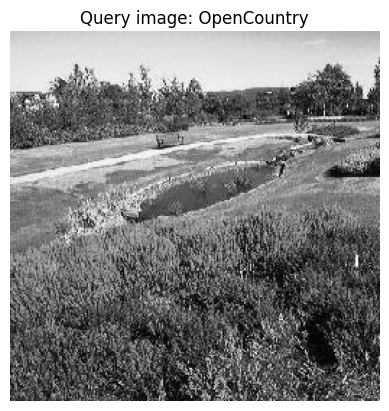

Query: data/scene/query/OpenCountry/image_0242.jpg
Top 1 match: data/scene/gallery/OpenCountry/image_0196.jpg, distance: 1.1349
Top 2 match: data/scene/gallery/OpenCountry/image_0146.jpg, distance: 1.1359
Top 3 match: data/scene/gallery/Mountain/image_0306.jpg, distance: 1.1398
Top 4 match: data/scene/gallery/OpenCountry/image_0342.jpg, distance: 1.1432
Top 5 match: data/scene/gallery/OpenCountry/image_0282.jpg, distance: 1.1439


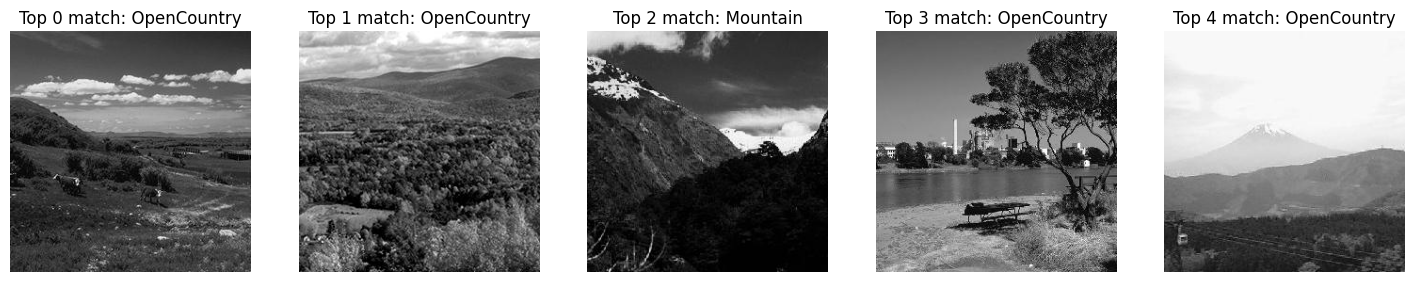

In [10]:
# query and evaluation
dist_list = []
display_random_numer = random.randint(0, len(query_image_file_list)-1)
for eachpic in range(len(gallery_all_feature_vgg_fc)):
    dist = cal_vec_dist(query_all_feature_vgg_fc[display_random_numer], gallery_all_feature_vgg_fc[eachpic])
    dist_list.append(dist)

# Find the top top_return similar results
dist_array = np.array(dist_list)
top_return = 5
index = np.argsort(dist_array)[:top_return]

plt.imshow(cv2.cvtColor(cv2.imread(query_image_file_list[display_random_numer]), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Query image: ' + query_image_file_list[display_random_numer].split("/")[3])
plt.show()

print("Query: %s" % (query_image_file_list[display_random_numer]))

# Display results
plt.figure(figsize=(18,8))
for i in range(top_return):
    plt.subplot(1,top_return,i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(gallery_image_file_list[index[i]]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Top ' + str(i) + ' match: ' + gallery_image_file_list[index[i]].split("/")[3])
    print("Top %d match: %s, distance: %.4f" % (i+1, gallery_image_file_list[index[i]], dist_array[index[i]]))
plt.show()

## Global pooling: Step 0, Define functions

- Reference: `Global sum-pooling`, Artem Babenko, Victor Lempitsky, "Aggregating Deep Convolutional Features for Image Retrieval," ICCV 2015, https://arxiv.org/abs/1510.07493
    
- Process
    - Extract the last conv layer output, then apply either global sum-pooling to generate features.
    - Apply cosine similarity (dot product) as the similarity score
    

In [11]:
# Define VGG baseline model
# The VGG model file (528 MB) will be downloaded from the Internet when you run this code for the first time.

vgg16_original = vgg.vgg16(pretrained=True)
vgg_model_extract_conv = vgg16_original
vgg_model_extract_conv.classifier = torch.nn.Sequential(*list(vgg16_original.classifier.children())[:-1])
vgg_model_extract_conv.to(device)

# A toy query the input and output dimension for the modified VGG model
temp_in = torch.rand(1, 3, 224, 224)
temp_in = temp_in.to(device)
print("vgg_model_extract_conv, input: ", temp_in.shape) # 1*3*224*224

temp_output = vgg_model_extract_conv.features[:31](temp_in)
print("vgg_model_extract_conv, 2D conv features: ", temp_output.shape) # 1*512*7*7


vgg_model_extract_conv, input:  torch.Size([1, 3, 224, 224])
vgg_model_extract_conv, 2D conv features:  torch.Size([1, 512, 7, 7])


In [12]:
# Define feature extraction function
# Note that the images in the dataset are gray scale images, we need to expand them into RGB images to feed into VGG model
transform = transforms.Compose([transforms.Resize((224, 224)),
                                transforms.ToTensor(),
                                transforms.Lambda(lambda x: torch.cat([x, x, x], 0))])

def extract_vgg_conv_feature_from_list(image_file_list, mode='sum'):
    all_feature = []
    for idx, eachFile in enumerate(image_file_list):
        img = Image.open(eachFile)
        x = transform(img).unsqueeze(0).to(device)
        conv_features = vgg_model_extract_conv.features[:31](x).cpu().detach().numpy().squeeze(0)

        if (mode == 'sum'):
            conv_features = np.sum(conv_features, axis=(1,2))
            conv_features = conv_features/np.linalg.norm(conv_features) # normalzie features
        else:
            print('extract_vgg_conv_feature_from_list: Wrong mode as input')
            break
        all_feature.append(conv_features.reshape(1, -1))
    return all_feature


## Global pooling: Step 1, Feature extraction from from both gallerying and query data set

In [13]:
# # Extract features from gallerying images
# gallery_all_feature_vgg_conv = extract_vgg_conv_feature_from_list(gallery_image_file_list, 'sum')
# np.save('data/pt_gallery_all_feature_vgg_conv.npy', gallery_all_feature_vgg_conv)
# print("gallery_all_feature_vgg_conv: (%d, %d)" % (len(gallery_all_feature_vgg_conv), gallery_all_feature_vgg_conv[0].shape[1]))

# # print('Extract features from query images')
# query_all_feature_vgg_conv = extract_vgg_conv_feature_from_list(query_image_file_list)
# print("query_all_feature_vgg_conv: (%d, %d)" % (len(query_all_feature_vgg_conv), query_all_feature_vgg_conv[0].shape[1]))
# np.save('data/pt_query_all_feature_vgg_conv.npy', query_all_feature_vgg_conv)

gallery_all_feature_vgg_conv = np.load('data/pt_gallery_all_feature_vgg_conv.npy')
query_all_feature_vgg_conv = np.load('data/pt_query_all_feature_vgg_conv.npy')
print("gallery_all_feature_vgg_conv: (%d, %d)" % (len(gallery_all_feature_vgg_conv), gallery_all_feature_vgg_conv[0].shape[1]))
print("query_all_feature_vgg_conv: (%d, %d)" % (len(query_all_feature_vgg_conv), query_all_feature_vgg_conv[0].shape[1]))


gallery_all_feature_vgg_conv: (1500, 512)
query_all_feature_vgg_conv: (150, 512)


## Global pooling: Step 2, Performance evaluation

In [14]:
##query and evaluation
avg_precision = []
avg_accuracy = []
top_return = 5
for i in range(len(query_all_feature_vgg_conv)):
    dist_list = []
    for eachpic in range(len(gallery_all_feature_vgg_conv)):
        dist = cal_vec_dist(query_all_feature_vgg_conv[i], gallery_all_feature_vgg_conv[eachpic])
        dist_list.append(dist)

    most_sim = np.array(dist_list)

    #choose the three nearest images of the given image
    index = np.argsort(most_sim)[:top_return]
    input_file_name = query_image_file_list[i]
    result_file_name_list = []
    for j in range(len(index)):
        result_file_name_list.append(gallery_image_file_list[index[j]])
    avg_precision.append(cal_precision(input_file_name, result_file_name_list))
    avg_accuracy.append(cal_accuracy(input_file_name, result_file_name_list))

print("Top %d return, mean Precision: %.4f" % (top_return, np.array(avg_precision).mean()))
print("Top %d return, mean Accuracy: %.4f" % (top_return, np.array(avg_accuracy).mean()))


Top 5 return, mean Precision: 0.6520
Top 5 return, mean Accuracy: 0.9467


## Global pooling: Step 3, Visualize the query results

- Randomly choose a query image (see `display_random_numer`).
- Calculate the distance between the query data `query_all_feature_vgg_conv[display_random_numer]` and all gallery data feature `gallery_all_feature_vgg_conv`.
- Sort the distance matrix and pick up the top return `top_return`.
- Visualize the query image, the top return images and their distances (smaller distances indicate higher similarity).

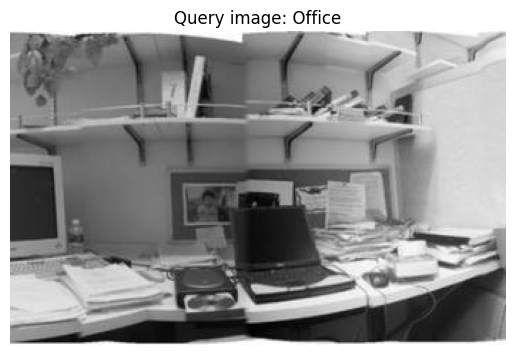

Query: data/scene/query/Office/image_0007.jpg
Top 1 match: data/scene/gallery/Office/image_0052.jpg, distance: 0.5402
Top 2 match: data/scene/gallery/Office/image_0008.jpg, distance: 0.5506
Top 3 match: data/scene/gallery/Office/image_0073.jpg, distance: 0.5540
Top 4 match: data/scene/gallery/Office/image_0045.jpg, distance: 0.5600
Top 5 match: data/scene/gallery/Kitchen/image_0148.jpg, distance: 0.5654


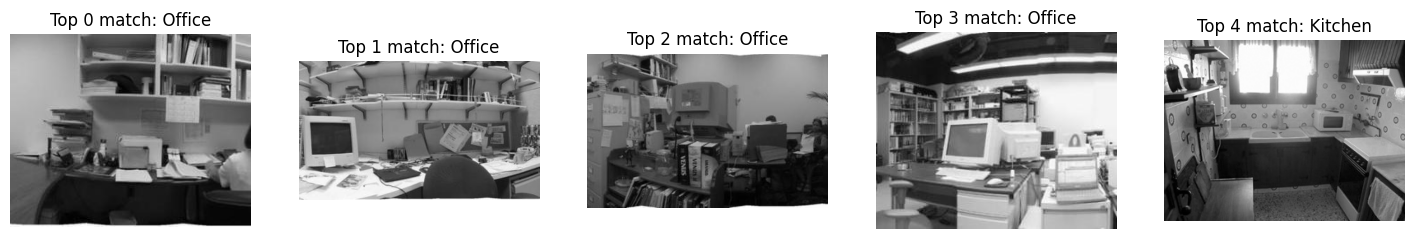

In [15]:
# Reference solution
dist_list = []
display_random_numer = random.randint(0, len(query_image_file_list)-1)
for eachpic in range(len(gallery_all_feature_vgg_conv)):
    dist = cal_vec_dist(query_all_feature_vgg_conv[display_random_numer], gallery_all_feature_vgg_conv[eachpic])
    dist_list.append(dist)

# Find the top top_return similar results
dist_array = np.array(dist_list)
top_return = 5
index = np.argsort(dist_array)[:top_return]

plt.imshow(cv2.cvtColor(cv2.imread(query_image_file_list[display_random_numer]), cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title('Query image: ' + query_image_file_list[display_random_numer].split("/")[3])
plt.show()

print("Query: %s" % (query_image_file_list[display_random_numer]))

# Display results
plt.figure(figsize=(18,8))
for i in range(top_return):
    plt.subplot(1,top_return,i+1)
    plt.imshow(cv2.cvtColor(cv2.imread(gallery_image_file_list[index[i]]), cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title('Top ' + str(i) + ' match: ' + gallery_image_file_list[index[i]].split("/")[3])
    print("Top %d match: %s, distance: %.4f" % (i+1, gallery_image_file_list[index[i]], dist_array[index[i]]))
plt.show()


$\color{red}{\text{Discussions}}$

Q1: The place recognition method is studied in this workshop. After the location (e.g., auditorium) is recognized, how can we further recognize a more detailed location (e.g., stage or front door of the auditorium)? Describe your solution and state additional data required (if any).

Q2: How do you want to revise the pretrained CNN-based feature to further get local details of the image?


In [16]:
# Provide your solution to Q1 here
#
#
# Provide your solution to Q2 here
#
#

**After you finish the workshop, rename and submit your .ipynb file.**